# Understanding Optimization and the Adam Algorithm

This notebook explains how BERT learns through optimization, focusing on the Adam optimizer.

## What You'll Learn:
1. Why we need sophisticated optimizers
2. From SGD to momentum to Adam
3. How Adam adapts learning rates per parameter
4. Learning rate scheduling strategies
5. How to monitor and tune optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.append('..')

np.random.seed(42)

# Set style for better visualizations - handle version compatibility
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid') 
    except OSError:
        plt.style.use('default')

## Part 1: The Optimization Problem

Training neural networks means finding parameters that minimize loss. Let's visualize this challenge.

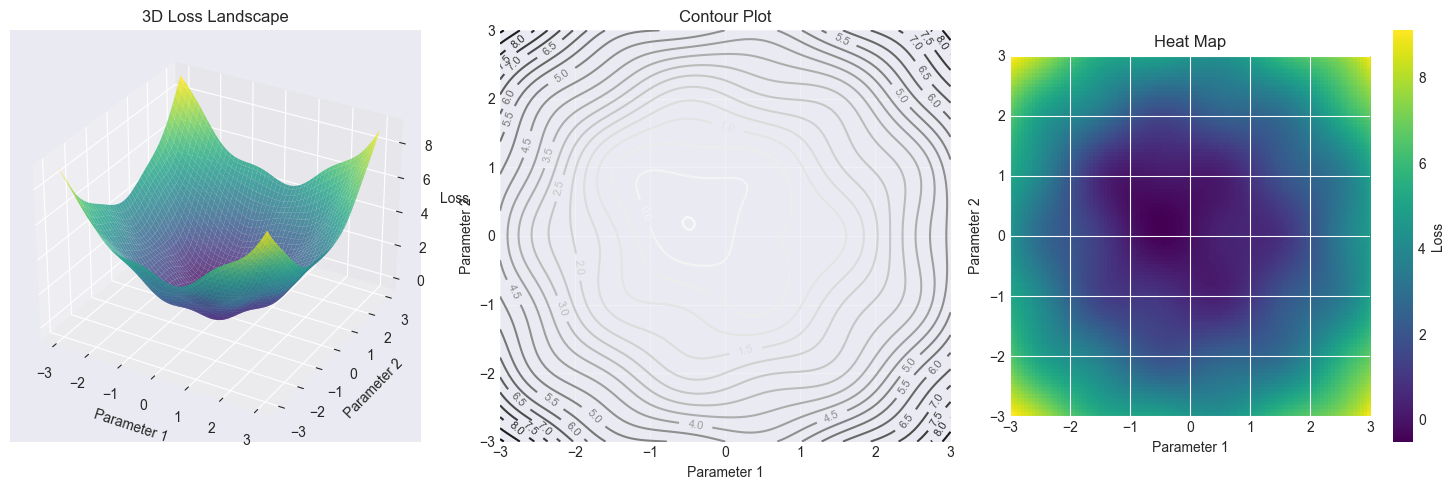

Neural network loss landscapes are:
- High-dimensional (millions of parameters)
- Non-convex (multiple local minima)
- Have flat regions and steep cliffs
- Different scales for different parameters


In [2]:
# Create a 2D loss landscape for visualization
def create_loss_landscape():
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    # Complex loss function with multiple minima
    Z = (X**2 + Y**2) * 0.5 + 0.3 * np.sin(3*X) * np.cos(3*Y) + \
        0.1 * np.exp(-(X+1)**2 - (Y-1)**2) * -10
    
    return X, Y, Z

# Visualize loss landscape
X, Y, Z = create_loss_landscape()

fig = plt.figure(figsize=(15, 5))

# 3D surface
ax1 = fig.add_subplot(131, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax1.set_title('3D Loss Landscape')
ax1.set_xlabel('Parameter 1')
ax1.set_ylabel('Parameter 2')
ax1.set_zlabel('Loss')

# Contour plot
ax2 = fig.add_subplot(132)
contour = ax2.contour(X, Y, Z, levels=20)
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_title('Contour Plot')
ax2.set_xlabel('Parameter 1')
ax2.set_ylabel('Parameter 2')
ax2.grid(True, alpha=0.3)

# Heat map
ax3 = fig.add_subplot(133)
heatmap = ax3.imshow(Z, extent=[-3, 3, -3, 3], origin='lower', cmap='viridis')
ax3.set_title('Heat Map')
ax3.set_xlabel('Parameter 1')
ax3.set_ylabel('Parameter 2')
plt.colorbar(heatmap, ax=ax3, label='Loss')

plt.tight_layout()
plt.show()

print("Neural network loss landscapes are:")
print("- High-dimensional (millions of parameters)")
print("- Non-convex (multiple local minima)")
print("- Have flat regions and steep cliffs")
print("- Different scales for different parameters")

## Part 2: From SGD to Adam

Let's understand the evolution of optimizers by implementing and comparing them.

In [3]:
class SGD:
    """Stochastic Gradient Descent"""
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def step(self, params, grads):
        """Update: θ = θ - η * ∇L"""
        return params - self.lr * grads

class SGDMomentum:
    """SGD with Momentum"""
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.velocity = None
    
    def step(self, params, grads):
        """Update with momentum: v = βv + η∇L, θ = θ - v"""
        if self.velocity is None:
            self.velocity = np.zeros_like(params)
        
        self.velocity = self.momentum * self.velocity + self.lr * grads
        return params - self.velocity

class Adam:
    """Adam Optimizer"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None  # First moment
        self.v = None  # Second moment
        self.t = 0     # Time step
    
    def step(self, params, grads):
        """Adam update"""
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        
        self.t += 1
        
        # Update biased moments
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * grads**2
        
        # Bias correction
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)
        
        # Update parameters
        return params - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

print("Optimizer Evolution:")
print("SGD → SGD+Momentum → RMSprop → Adam")
print("\nEach improvement addresses specific problems:")
print("- Momentum: Overcomes oscillations")
print("- RMSprop: Adapts to parameter scale")
print("- Adam: Combines both + bias correction")

Optimizer Evolution:
SGD → SGD+Momentum → RMSprop → Adam

Each improvement addresses specific problems:
- Momentum: Overcomes oscillations
- RMSprop: Adapts to parameter scale
- Adam: Combines both + bias correction


### Comparing Optimizers Visually

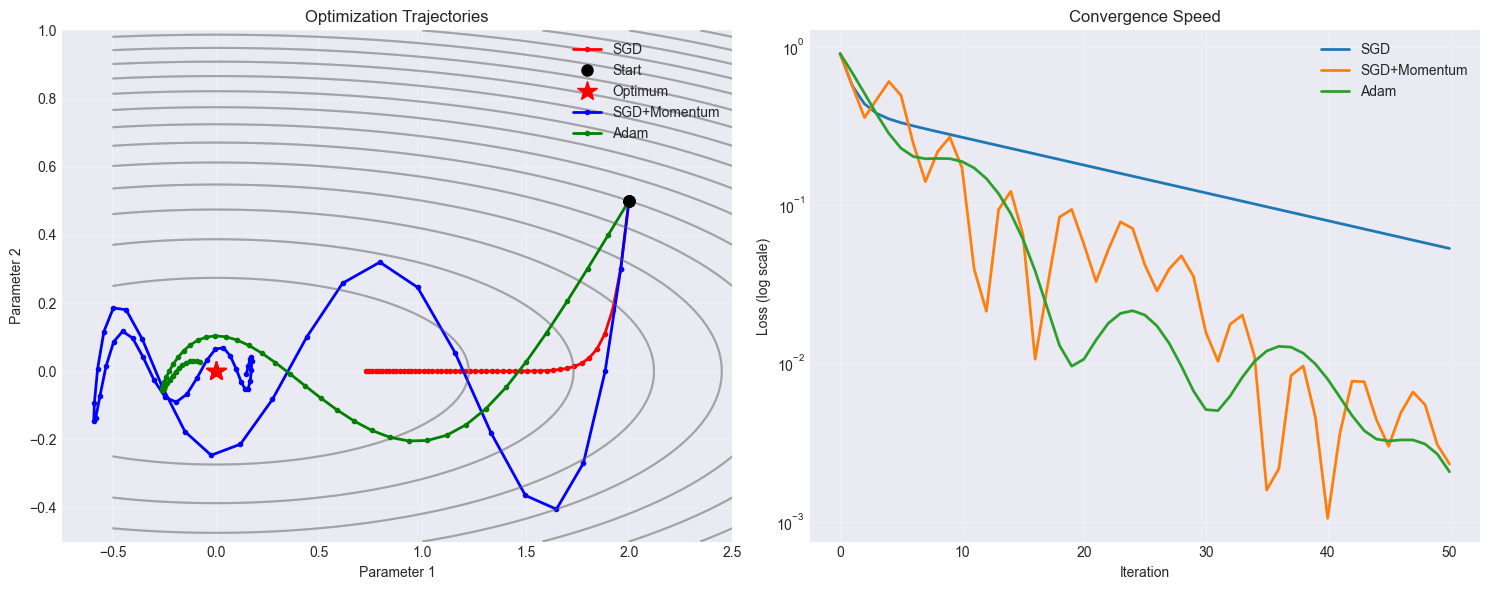

Final distances from optimum:
SGD         : 0.728339
SGD+Momentum: 0.148094
Adam        : 0.080538


In [4]:
# Simple 2D optimization problem
def objective_function(x, y):
    """Elliptical function - different scales for x and y"""
    return 0.1 * x**2 + 2 * y**2

def compute_gradient(x, y):
    """Gradient of objective function"""
    grad_x = 0.2 * x
    grad_y = 4 * y
    return np.array([grad_x, grad_y])

# Run optimization with different optimizers
def run_optimization(optimizer, start_point, num_steps=50):
    """Run optimization and return trajectory"""
    trajectory = [start_point.copy()]
    params = start_point.copy()
    
    for _ in range(num_steps):
        grad = compute_gradient(params[0], params[1])
        params = optimizer.step(params, grad)
        trajectory.append(params.copy())
    
    return np.array(trajectory)

# Starting point
start = np.array([2.0, 0.5])

# Create optimizers
optimizers = {
    'SGD': SGD(lr=0.1),
    'SGD+Momentum': SGDMomentum(lr=0.1, momentum=0.9),
    'Adam': Adam(lr=0.1)
}

# Run optimizations
trajectories = {}
for name, optimizer in optimizers.items():
    trajectories[name] = run_optimization(optimizer, start)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create contour plot
x_range = np.linspace(-0.5, 2.5, 100)
y_range = np.linspace(-0.5, 1.0, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = objective_function(X_grid, Y_grid)

# Plot trajectories
colors = ['red', 'blue', 'green']
for i, (name, trajectory) in enumerate(trajectories.items()):
    ax1.contour(X_grid, Y_grid, Z_grid, levels=20, alpha=0.3, colors='gray')
    ax1.plot(trajectory[:, 0], trajectory[:, 1], 
             color=colors[i], linewidth=2, marker='o', markersize=3, label=name)
    ax1.plot(start[0], start[1], 'ko', markersize=8, label='Start' if i == 0 else '')
    ax1.plot(0, 0, 'r*', markersize=15, label='Optimum' if i == 0 else '')

ax1.set_xlabel('Parameter 1')
ax1.set_ylabel('Parameter 2')
ax1.set_title('Optimization Trajectories')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss over time
for name, trajectory in trajectories.items():
    losses = [objective_function(x, y) for x, y in trajectory]
    ax2.semilogy(losses, linewidth=2, label=name)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss (log scale)')
ax2.set_title('Convergence Speed')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print("Final distances from optimum:")
for name, trajectory in trajectories.items():
    final_point = trajectory[-1]
    distance = np.sqrt(final_point[0]**2 + final_point[1]**2)
    print(f"{name:12s}: {distance:.6f}")

## Part 3: Understanding Adam in Detail

Let's break down exactly how Adam works.

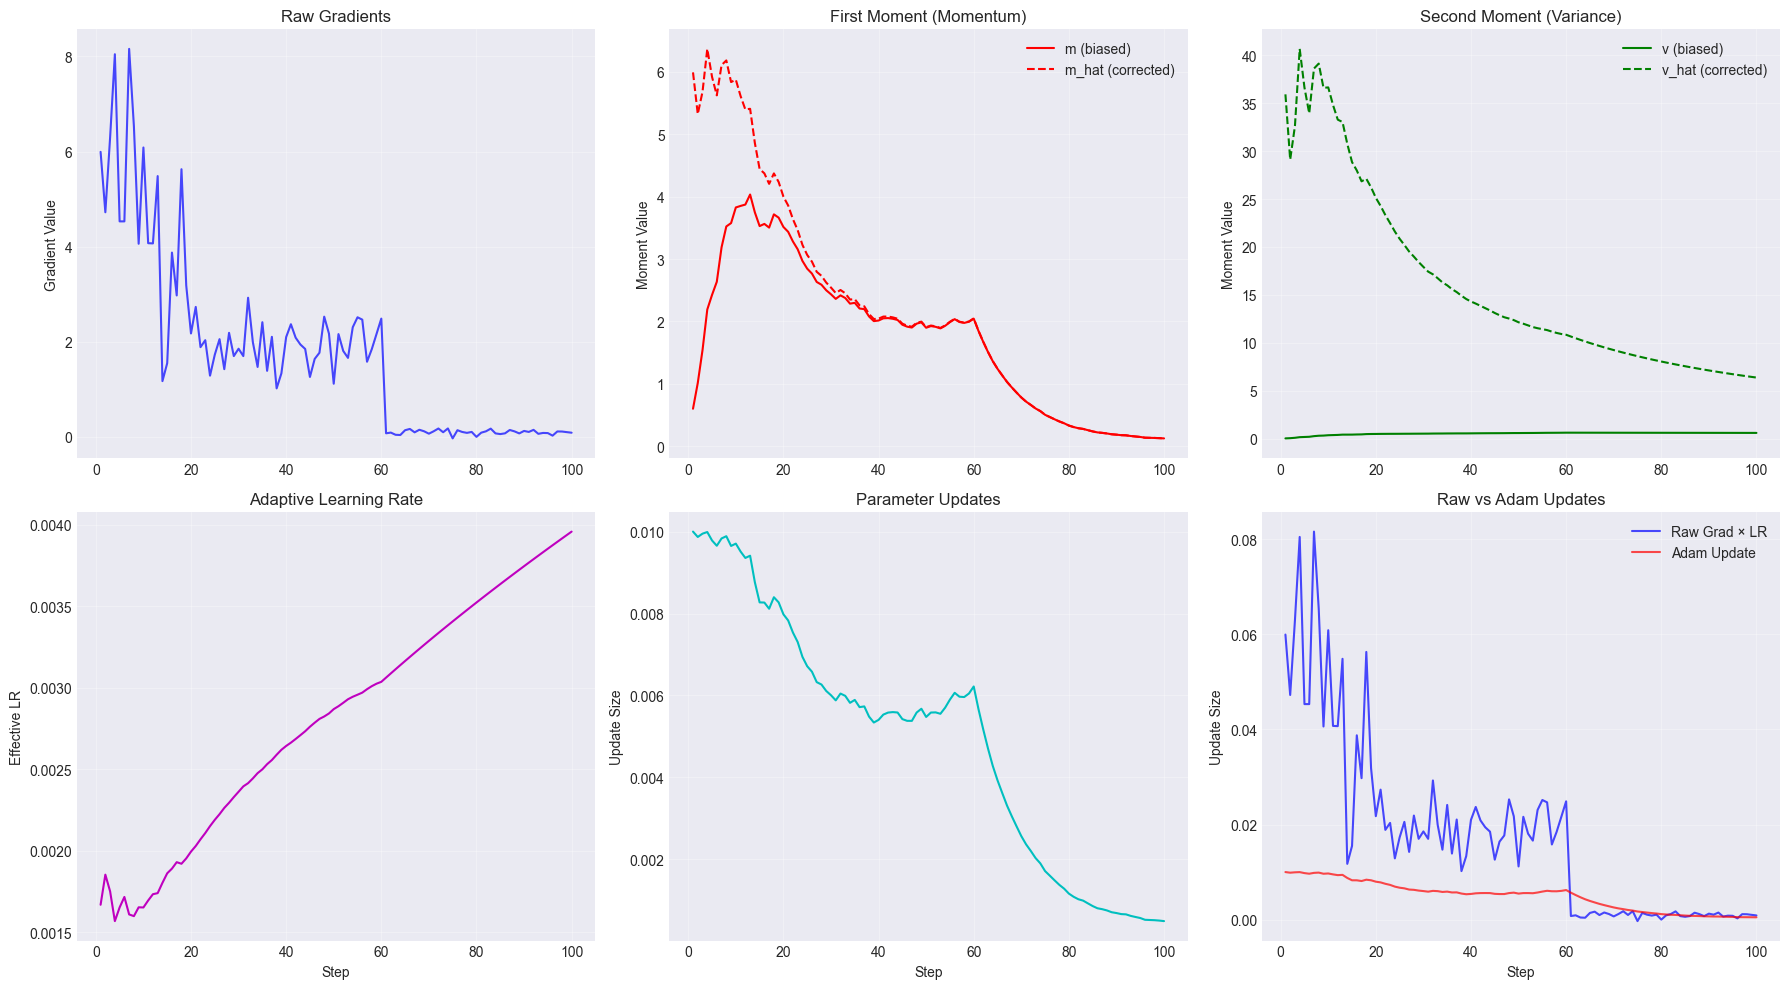

Key Adam Features:
1. Momentum (m): Smooths gradient direction
2. Adaptive rate: Larger updates for infrequent gradients
3. Bias correction: Compensates for initialization bias
4. Automatic scaling: Works across different parameter scales


In [5]:
class AdamDetailed:
    """Adam with detailed tracking for educational purposes"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.reset()
    
    def reset(self):
        self.m = 0  # First moment
        self.v = 0  # Second moment  
        self.t = 0  # Time step
        self.history = {
            'gradients': [],
            'm': [],
            'v': [],
            'm_hat': [],
            'v_hat': [],
            'updates': [],
            'adaptive_lr': []
        }
    
    def step(self, gradient):
        """Single Adam update step with tracking"""
        self.t += 1
        
        # Update biased first moment estimate
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradient
        
        # Update biased second moment estimate
        self.v = self.beta2 * self.v + (1 - self.beta2) * gradient**2
        
        # Compute bias-corrected moments
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)
        
        # Compute adaptive learning rate
        adaptive_lr = self.lr / (np.sqrt(v_hat) + self.eps)
        
        # Compute update
        update = adaptive_lr * m_hat
        
        # Store history
        self.history['gradients'].append(gradient)
        self.history['m'].append(self.m)
        self.history['v'].append(self.v)
        self.history['m_hat'].append(m_hat)
        self.history['v_hat'].append(v_hat)
        self.history['updates'].append(update)
        self.history['adaptive_lr'].append(adaptive_lr)
        
        return update

# Simulate gradient sequence with different characteristics
def simulate_gradients(n_steps=100):
    """Generate synthetic gradient sequence"""
    gradients = []
    
    for i in range(n_steps):
        # Different phases of training
        if i < 20:
            # Large, noisy gradients (early training)
            grad = 5.0 + np.random.normal(0, 2)
        elif i < 60:
            # Medium gradients with some noise
            grad = 2.0 + np.random.normal(0, 0.5)
        else:
            # Small gradients (near convergence)
            grad = 0.1 + np.random.normal(0, 0.05)
        
        gradients.append(grad)
    
    return gradients

# Run detailed Adam analysis
adam = AdamDetailed(lr=0.01)
gradients = simulate_gradients()

# Process each gradient
for grad in gradients:
    adam.step(grad)

# Visualize Adam's behavior
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

steps = range(1, len(gradients) + 1)

# Raw gradients
axes[0, 0].plot(steps, adam.history['gradients'], 'b-', alpha=0.7)
axes[0, 0].set_title('Raw Gradients')
axes[0, 0].set_ylabel('Gradient Value')
axes[0, 0].grid(True, alpha=0.3)

# First moment (momentum)
axes[0, 1].plot(steps, adam.history['m'], 'r-', label='m (biased)')
axes[0, 1].plot(steps, adam.history['m_hat'], 'r--', label='m_hat (corrected)')
axes[0, 1].set_title('First Moment (Momentum)')
axes[0, 1].set_ylabel('Moment Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Second moment (variance)
axes[0, 2].plot(steps, adam.history['v'], 'g-', label='v (biased)')
axes[0, 2].plot(steps, adam.history['v_hat'], 'g--', label='v_hat (corrected)')
axes[0, 2].set_title('Second Moment (Variance)')
axes[0, 2].set_ylabel('Moment Value')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Adaptive learning rate
axes[1, 0].plot(steps, adam.history['adaptive_lr'], 'm-')
axes[1, 0].set_title('Adaptive Learning Rate')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Effective LR')
axes[1, 0].grid(True, alpha=0.3)

# Updates
axes[1, 1].plot(steps, adam.history['updates'], 'c-')
axes[1, 1].set_title('Parameter Updates')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Update Size')
axes[1, 1].grid(True, alpha=0.3)

# Comparison: raw gradient vs Adam update
axes[1, 2].plot(steps, np.array(adam.history['gradients']) * 0.01, 
                'b-', alpha=0.7, label='Raw Grad × LR')
axes[1, 2].plot(steps, adam.history['updates'], 
                'r-', alpha=0.7, label='Adam Update')
axes[1, 2].set_title('Raw vs Adam Updates')
axes[1, 2].set_xlabel('Step')
axes[1, 2].set_ylabel('Update Size')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Adam Features:")
print("1. Momentum (m): Smooths gradient direction")
print("2. Adaptive rate: Larger updates for infrequent gradients")
print("3. Bias correction: Compensates for initialization bias")
print("4. Automatic scaling: Works across different parameter scales")

## Part 4: Learning Rate Scheduling

The learning rate is crucial. Let's explore different scheduling strategies.

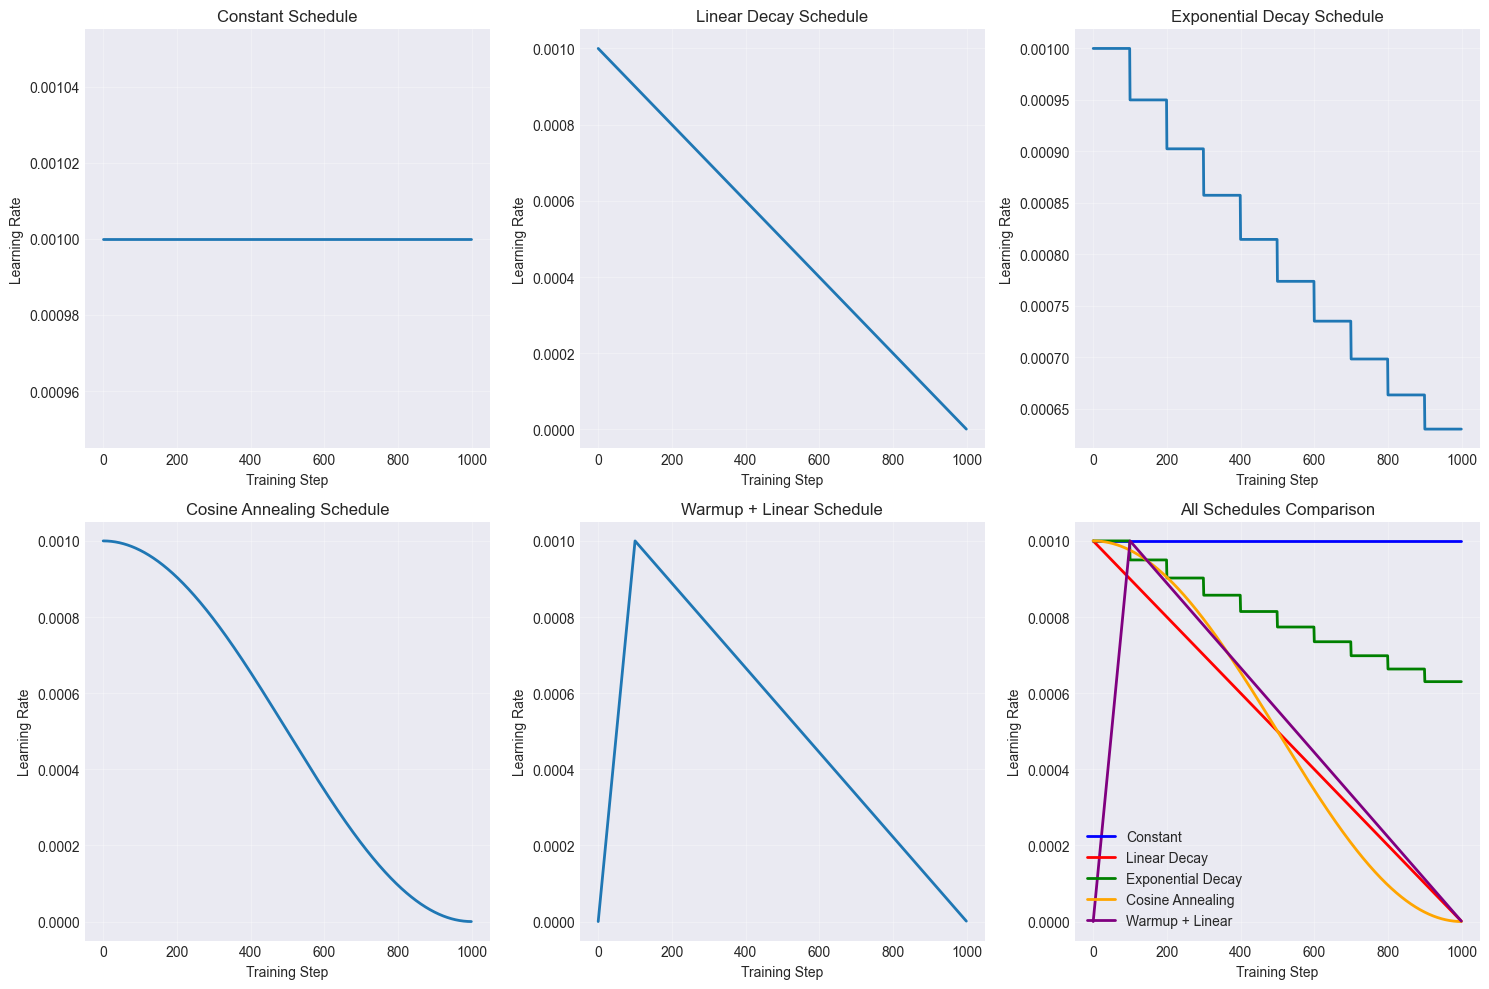

Learning Rate Schedule Guidelines:
- Warmup: Prevents instability in early training
- Decay: Allows fine-tuning as training progresses
- Cosine: Smooth transitions, good for fine-tuning
- Choice depends on problem and training length


In [6]:
class LearningRateScheduler:
    """Different learning rate schedules"""
    
    @staticmethod
    def constant(step, initial_lr=0.001, **kwargs):
        """Constant learning rate"""
        return initial_lr
    
    @staticmethod
    def linear_decay(step, initial_lr=0.001, total_steps=1000, **kwargs):
        """Linear decay to zero"""
        decay_factor = max(0, 1 - step / total_steps)
        return initial_lr * decay_factor
    
    @staticmethod
    def exponential_decay(step, initial_lr=0.001, decay_rate=0.95, decay_steps=100, **kwargs):
        """Exponential decay"""
        return initial_lr * (decay_rate ** (step // decay_steps))
    
    @staticmethod
    def cosine_annealing(step, initial_lr=0.001, total_steps=1000, **kwargs):
        """Cosine annealing"""
        return initial_lr * 0.5 * (1 + np.cos(np.pi * step / total_steps))
    
    @staticmethod
    def warmup_linear(step, initial_lr=0.001, warmup_steps=100, total_steps=1000, **kwargs):
        """Linear warmup followed by linear decay"""
        if step < warmup_steps:
            # Warmup: linearly increase from 0 to initial_lr
            return initial_lr * step / warmup_steps
        else:
            # Decay: linearly decrease to 0
            remaining_steps = total_steps - warmup_steps
            decay_step = step - warmup_steps
            decay_factor = max(0, 1 - decay_step / remaining_steps)
            return initial_lr * decay_factor

# Visualize different schedules
total_steps = 1000
steps = np.arange(total_steps)

schedules = {
    'Constant': LearningRateScheduler.constant,
    'Linear Decay': LearningRateScheduler.linear_decay,
    'Exponential Decay': LearningRateScheduler.exponential_decay,
    'Cosine Annealing': LearningRateScheduler.cosine_annealing,
    'Warmup + Linear': LearningRateScheduler.warmup_linear
}

plt.figure(figsize=(15, 10))

for i, (name, scheduler) in enumerate(schedules.items()):
    plt.subplot(2, 3, i + 1)
    
    if name == 'Warmup + Linear':
        lrs = [scheduler(step, warmup_steps=100, total_steps=total_steps) for step in steps]
    else:
        lrs = [scheduler(step, total_steps=total_steps) for step in steps]
    
    plt.plot(steps, lrs, linewidth=2)
    plt.title(f'{name} Schedule')
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.grid(True, alpha=0.3)

# Comparison plot
plt.subplot(2, 3, 6)
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, (name, scheduler) in enumerate(schedules.items()):
    if name == 'Warmup + Linear':
        lrs = [scheduler(step, warmup_steps=100, total_steps=total_steps) for step in steps]
    else:
        lrs = [scheduler(step, total_steps=total_steps) for step in steps]
    
    plt.plot(steps, lrs, color=colors[i], linewidth=2, label=name)

plt.title('All Schedules Comparison')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Learning Rate Schedule Guidelines:")
print("- Warmup: Prevents instability in early training")
print("- Decay: Allows fine-tuning as training progresses")
print("- Cosine: Smooth transitions, good for fine-tuning")
print("- Choice depends on problem and training length")

## Part 5: Adam in Mini-BERT

Let's examine how Adam is implemented in our Mini-BERT.

In [7]:
from optimizer import AdamW
from model import MiniBERT
import numpy as np

# Create model and optimizer
model = MiniBERT()
optimizer = AdamW(
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    weight_decay=0.01
)

print("Mini-BERT Adam Configuration:")
print(f"Learning rate: {optimizer.learning_rate}")
print(f"Beta1 (momentum): {optimizer.beta1}")
print(f"Beta2 (RMSprop): {optimizer.beta2}")
print(f"Epsilon: {optimizer.eps}")
print(f"Weight decay: {optimizer.weight_decay}")

# Get model parameters
param_dict = model.params

print(f"\nOptimizing {len(param_dict)} parameter tensors:")
for i, (name, param) in enumerate(param_dict.items()):
    if i < 10:  # Show first 10
        print(f"  {name}: shape {param.shape}")
    elif i == 10:
        print(f"  ... and {len(param_dict) - 10} more")

# Simulate one optimization step
dummy_gradients = {}
for name, param in param_dict.items():
    # Create dummy gradients (normally from backprop)
    dummy_gradients[name] = np.random.randn(*param.shape) * 0.001

# Apply optimizer step
updated_params = optimizer.step(param_dict, dummy_gradients)

# Analyze moment statistics
print("\nAdam Moment Statistics (after 1 step):")
for i, name in enumerate(list(param_dict.keys())[:5]):
    if name in optimizer.m:
        m_norm = np.linalg.norm(optimizer.m[name])
        v_norm = np.linalg.norm(optimizer.v[name])
        print(f"  {name}: m_norm={m_norm:.6f}, v_norm={v_norm:.6f}")

Initialized Mini-BERT: 4,498,880 parameters (4.50M)
AdamW optimizer initialized:
  learning_rate: 0.001
  beta1: 0.9, beta2: 0.999
  eps: 1e-08, weight_decay: 0.01
Mini-BERT Adam Configuration:
Learning rate: 0.001
Beta1 (momentum): 0.9
Beta2 (RMSprop): 0.999
Epsilon: 1e-08
Weight decay: 0.01

Optimizing 42 parameter tensors:
  token_embeddings: shape (8192, 192)
  position_embeddings: shape (64, 192)
  W_Q_0: shape (192, 192)
  W_K_0: shape (192, 192)
  W_V_0: shape (192, 192)
  W_O_0: shape (192, 192)
  ln1_gamma_0: shape (192,)
  ln1_beta_0: shape (192,)
  W1_0: shape (192, 768)
  b1_0: shape (768,)
  ... and 32 more



Adam Moment Statistics (after 1 step):
  token_embeddings: m_norm=0.125532, v_norm=0.000002
  position_embeddings: m_norm=0.011091, v_norm=0.000000
  W_Q_0: m_norm=0.019132, v_norm=0.000000
  W_K_0: m_norm=0.019212, v_norm=0.000000
  W_V_0: m_norm=0.019089, v_norm=0.000000


## Part 6: Monitoring Optimization

How do we know if optimization is working well?

Initialized Mini-BERT: 4,498,880 parameters (4.50M)
AdamW optimizer initialized:
  learning_rate: 0.001
  beta1: 0.9, beta2: 0.999
  eps: 1e-08, weight_decay: 0.01


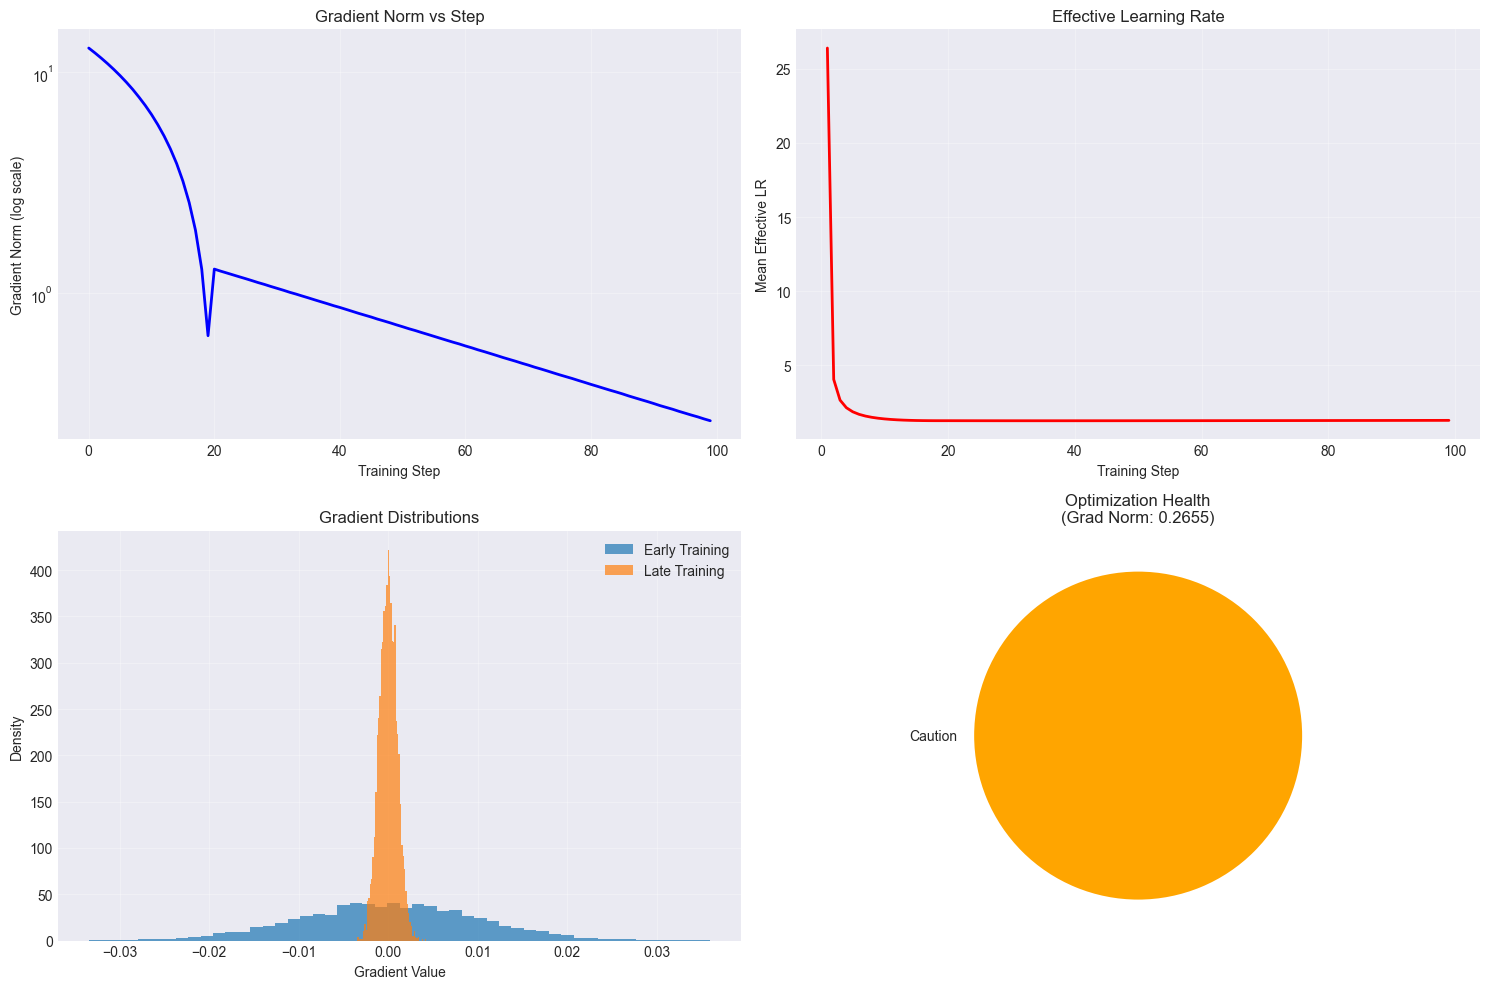


Optimization Health Checklist:
✓ Gradient norms decrease over time
✓ No NaN or inf values in gradients
✓ Effective learning rates adapt appropriately
✓ Loss decreases (not shown here)
✓ Parameters update but don't explode


In [8]:
def analyze_optimization_health(gradients_dict, optimizer, step):
    """
    Analyze optimization health from gradients and optimizer state.
    """
    metrics = {}
    
    # Gradient statistics
    all_grads = np.concatenate([g.flatten() for g in gradients_dict.values()])
    metrics['grad_norm'] = np.linalg.norm(all_grads)
    metrics['grad_mean'] = np.mean(all_grads)
    metrics['grad_std'] = np.std(all_grads)
    metrics['grad_max'] = np.max(np.abs(all_grads))
    
    # Check for problematic gradients
    metrics['num_zero_grads'] = np.sum(all_grads == 0)
    metrics['num_inf_grads'] = np.sum(~np.isfinite(all_grads))
    
    # Optimizer state (for Adam)
    if hasattr(optimizer, 'm') and step > 0:
        all_m = np.concatenate([m.flatten() for m in optimizer.m.values()])
        all_v = np.concatenate([v.flatten() for v in optimizer.v.values()])
        
        metrics['momentum_norm'] = np.linalg.norm(all_m)
        metrics['velocity_norm'] = np.linalg.norm(all_v)
        
        # Effective learning rates
        effective_lrs = optimizer.learning_rate / (np.sqrt(all_v) + optimizer.eps)
        metrics['effective_lr_mean'] = np.mean(effective_lrs)
        metrics['effective_lr_std'] = np.std(effective_lrs)
    
    return metrics

# Simulate training monitoring
model = MiniBERT()
optimizer = AdamW(learning_rate=0.001)

# Simulate several training steps
num_steps = 100
monitoring_data = []

for step in range(num_steps):
    # Simulate gradients that change over training
    gradients = {}
    
    # Use actual parameter names from model
    param_names = list(model.params.keys())[:4]  # First 4 parameters
    
    for name in param_names:
        param = model.params[name]
        
        # Simulate realistic gradient evolution
        if step < 20:
            # Large gradients early
            scale = 0.01 * (1 - step / 20)
        else:
            # Smaller gradients later
            scale = 0.001 * np.exp(-(step - 20) / 50)
        
        gradients[name] = np.random.randn(*param.shape) * scale
    
    # Analyze optimization health
    metrics = analyze_optimization_health(gradients, optimizer, step)
    metrics['step'] = step
    monitoring_data.append(metrics)
    
    # Apply optimizer step
    dummy_params = {name: model.params[name] for name in param_names}
    optimizer.step(dummy_params, gradients)

# Convert to arrays for plotting
steps = [m['step'] for m in monitoring_data]
grad_norms = [m['grad_norm'] for m in monitoring_data]
effective_lr_means = [m.get('effective_lr_mean', 0) for m in monitoring_data[1:]]

# Visualize optimization health
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gradient norm over time
axes[0, 0].semilogy(steps, grad_norms, 'b-', linewidth=2)
axes[0, 0].set_title('Gradient Norm vs Step')
axes[0, 0].set_xlabel('Training Step')
axes[0, 0].set_ylabel('Gradient Norm (log scale)')
axes[0, 0].grid(True, alpha=0.3)

# Effective learning rate
axes[0, 1].plot(steps[1:], effective_lr_means, 'r-', linewidth=2)
axes[0, 1].set_title('Effective Learning Rate')
axes[0, 1].set_xlabel('Training Step')
axes[0, 1].set_ylabel('Mean Effective LR')
axes[0, 1].grid(True, alpha=0.3)

# Gradient distribution at different steps
early_grads = np.concatenate([np.random.randn(1000) * 0.01 for _ in range(5)])
late_grads = np.concatenate([np.random.randn(1000) * 0.001 for _ in range(5)])

axes[1, 0].hist(early_grads, bins=50, alpha=0.7, label='Early Training', density=True)
axes[1, 0].hist(late_grads, bins=50, alpha=0.7, label='Late Training', density=True)
axes[1, 0].set_title('Gradient Distributions')
axes[1, 0].set_xlabel('Gradient Value')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Optimization health indicators
health_indicators = ['Good', 'Caution', 'Problem']
health_colors = ['green', 'orange', 'red']

# Simple health assessment based on gradient norms
current_grad_norm = grad_norms[-1]
if current_grad_norm > 1.0:
    health_status = 2  # Problem
elif current_grad_norm > 0.1:
    health_status = 1  # Caution
else:
    health_status = 0  # Good

axes[1, 1].pie([1], colors=[health_colors[health_status]], labels=[health_indicators[health_status]])
axes[1, 1].set_title(f'Optimization Health\n(Grad Norm: {current_grad_norm:.4f})')

plt.tight_layout()
plt.show()

print("\nOptimization Health Checklist:")
print("✓ Gradient norms decrease over time")
print("✓ No NaN or inf values in gradients")
print("✓ Effective learning rates adapt appropriately")
print("✓ Loss decreases (not shown here)")
print("✓ Parameters update but don't explode")

## Summary: Key Concepts

### 1. **Why Adam Works**
- **Momentum**: Smooths noisy gradients
- **Adaptive rates**: Different scales for different parameters
- **Bias correction**: Handles initialization bias
- **Robust**: Works across many problems

### 2. **Adam Formula**
```
m_t = β₁ * m_{t-1} + (1-β₁) * g_t
v_t = β₂ * v_{t-1} + (1-β₂) * g_t²
m̂_t = m_t / (1-β₁ᵗ)
v̂_t = v_t / (1-β₂ᵗ)
θ_t = θ_{t-1} - α * m̂_t / (√v̂_t + ε)
```

### 3. **Learning Rate Scheduling**
- **Warmup**: Start small, prevent instability
- **Decay**: Reduce over time for fine-tuning
- **Schedule choice**: Depends on problem

### 4. **Monitoring**
- Watch gradient norms
- Check for NaN/inf
- Monitor effective learning rates
- Track loss convergence

## Exercises

1. **Hyperparameter Sensitivity**: How does changing β₁ and β₂ affect convergence? Try β₁=0.8 vs 0.95.

2. **Learning Rate Finder**: Implement a learning rate finder that gradually increases LR to find the optimal range.

3. **Optimizer Comparison**: Compare Adam vs SGD+Momentum on the same problem. When does each work better?

4. **Weight Decay**: Add L2 regularization to Adam. How does it affect the update rule?

In [9]:
# Space for your experiments
